## Baro Array - Coherence

### Importing

In [1]:
import os
import gc
import numpy as np
import matplotlib.pyplot as plt
import obspy
import pandas as pd

from obspy import Stream

from andbro__compute_coherence_stream import __coherence_stream
from andbro__read_sds import __read_sds

from functions.interpolate_nan import __interpolate_nan

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

### Setting Variables

In [3]:
config = {}

config['klim'] = 50.
config['kstep'] = config['klim'] / 100.

# example 1
config['tbeg'] = obspy.UTCDateTime("2024-03-16 06:00")
config['tend'] = obspy.UTCDateTime("2024-03-16 18:00")

# example 2
# config['tbeg'] = obspy.UTCDateTime("2024-03-23 06:00")
# config['tend'] = obspy.UTCDateTime("2024-03-23 17:00")

config['tbeg'] = obspy.UTCDateTime("2024-03-23 00:00")
config['tend'] = obspy.UTCDateTime("2024-03-25 00:00")

config['seeds'] = [
                   'BW.PROMY.01.LDI',
                   'BW.PROMY.03.LDI',
                   'BW.PROMY.04.LDI',
                   'BW.PROMY.05.LDI',
                   'BW.PROMY.07.LDI',
                   'BW.PROMY.09.LDI',
]

config['fmin'] = 0.5e-4
config['fmax'] = 0.1

config['path_to_figs'] = data_path+"/LNM2/figures/"


### Load FURT Data

In [4]:
from andbro__load_FURT_stream import __load_furt_stream

In [5]:
furt = __load_furt_stream(config['tbeg']-60, config['tend']+60, path_to_archive=bay_path+'gif_online/FURT/WETTER/')

/home/brotzer/andbro_python/andbro__load_FURT_stream.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['datetime'] = to_datetime(df['datetime'], format="%d%m%y %H%M%S", errors="ignore")


In [6]:
for tr in furt:
    if np.isnan(tr.data).any():
        print("-> NaN found")
        tr.data = __interpolate_nan(tr.data)

for tr in furt:
    if tr.stats.channel == "LAP":
        tr.data *= 100

furt = furt.trim(config['tbeg'], config['tend'])
furt = furt.detrend("simple")
furt = furt.taper(0.01, type="cosine")
furt = furt.filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], corners=4, zerophase=True)
furt = furt.resample(config['fmax']*4)


-> NaN found
-> NaN found
-> NaN found
-> NaN found
-> NaN found
-> NaN found


### Load Pressure Data

1 Trace(s) in Stream:
BW.PROMY.01.LDI | 2024-03-23T00:00:00.000000Z - 2024-03-25T00:00:00.000000Z | 1.0 Hz, 172801 samples


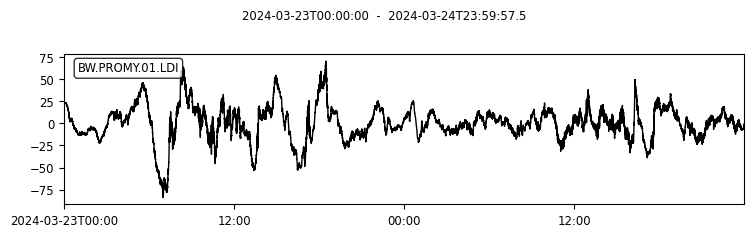

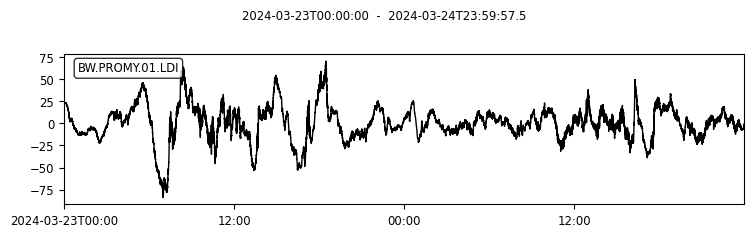

1 Trace(s) in Stream:
BW.PROMY.03.LDI | 2024-03-23T00:00:00.000000Z - 2024-03-25T00:00:00.000000Z | 1.0 Hz, 172801 samples


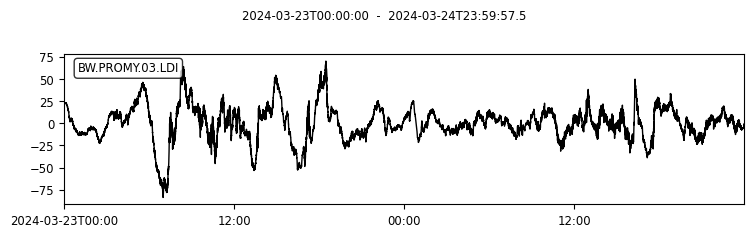

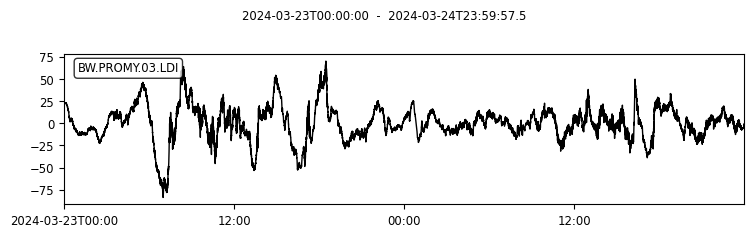

1 Trace(s) in Stream:
BW.PROMY.04.LDI | 2024-03-23T00:00:00.000000Z - 2024-03-25T00:00:00.000000Z | 1.0 Hz, 172801 samples


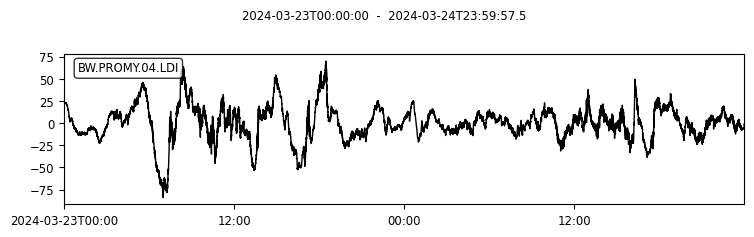

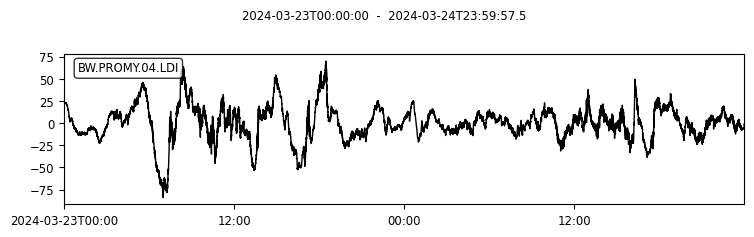

1 Trace(s) in Stream:
BW.PROMY.05.LDI | 2024-03-23T00:00:00.000000Z - 2024-03-25T00:00:00.000000Z | 1.0 Hz, 172801 samples


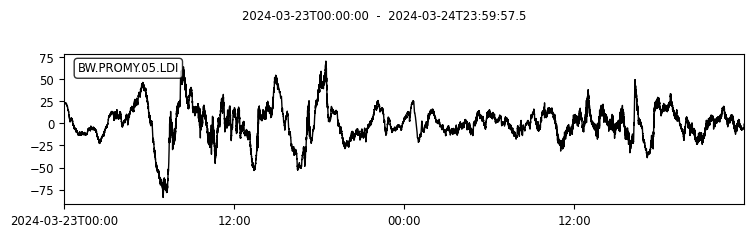

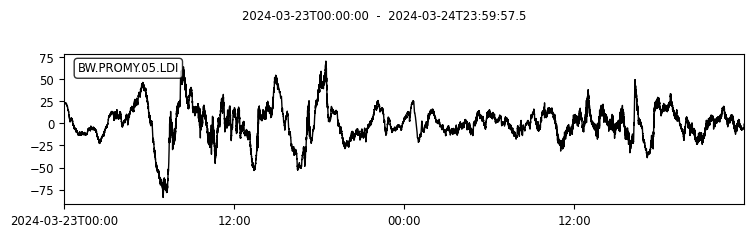

1 Trace(s) in Stream:
BW.PROMY.07.LDI | 2024-03-23T00:00:00.000000Z - 2024-03-25T00:00:00.000000Z | 1.0 Hz, 172801 samples


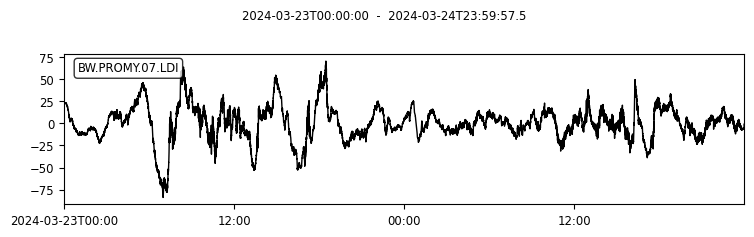

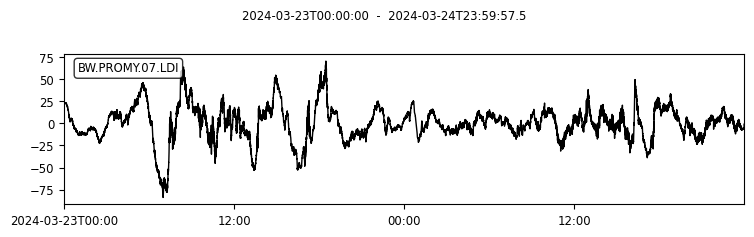

1 Trace(s) in Stream:
BW.PROMY.09.LDI | 2024-03-23T00:00:00.000000Z - 2024-03-25T00:00:00.000000Z | 1.0 Hz, 172801 samples


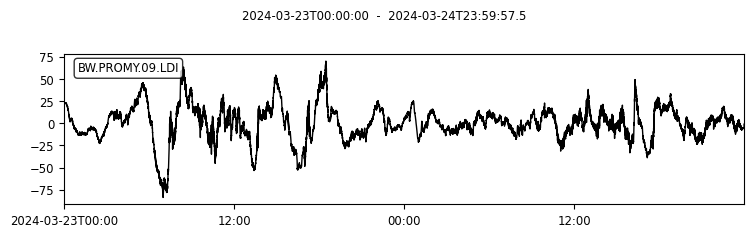

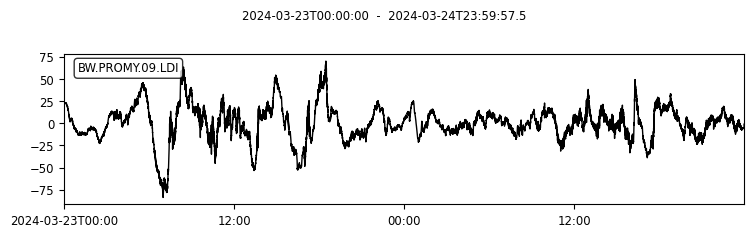

In [7]:
df_pressure = pd.DataFrame()

st = Stream()

for _i, seed in enumerate(config['seeds']):

    # if "ROMY" in seed:
    #     seed = "BW.PROMY.03.LDI"

    ps = __read_sds(archive_path+"temp_archive/", seed, config['tbeg'], config['tend'])
    print(ps)

    for tr in ps:
        if np.isnan(tr.data).any():
            print("-> NaN found")
            tr.data = __interpolate_nan(tr.data)

    try:
        # convert from Pa to hPa
        if "03" in seed:
            ps[0].data = ps[0].data / 100

        ps = ps.detrend("simple")

        ps = ps.taper(0.01, type="cosine")

        ps = ps.filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], corners=4, zerophase=True)

        ps = ps.resample(config['fmax']*4)

        # convert from hPa to Pa
        ps[0].data = ps[0].data * 100

        if _i == 0:
            df_pressure["time"] = ps[0].times(reftime=config['tbeg'])

        df_pressure[f"{seed.split('.')[0]}.{seed.split('.')[1]}"] = ps[0].data

        ps.plot();

        st += ps

    except:
        print(f"Error: {seed}")

st += furt.select(channel="LAP")

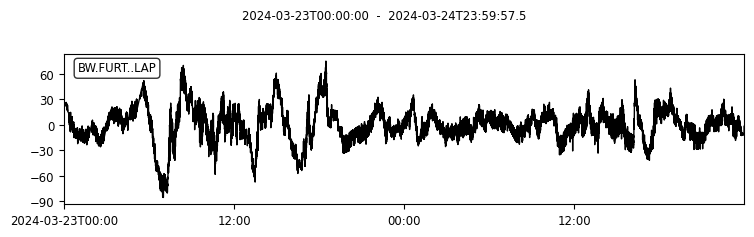

In [8]:
st.select(station="FURT").plot();

### Compute Coherence

In [9]:
from functions.coherence_multitaper_stream import __coherence_multitaper_stream
from functions.coherence_welch_stream import __coherence_welch_stream

In [16]:
twin = 10*3600 # seconds
print(twin/3600, "hours")

nseg = st[0].stats.sampling_rate*twin
nover = 0.5*nseg

# compute coherence using welch
# ff, coh = __coherence_welch_stream(st, st.select(station="FURT", location="")[0], nseg=nseg, nover=nover)
ff, coh = __coherence_welch_stream(st, st.select(station="PROMY", location="03")[0], nseg=nseg, nover=nover)

# compute coherence using multitaper BW.PROMY.03.LDI
# ff, coh = __coherence_multitaper_stream(st, "BW.PROMY.03.LDI", n_win=10, time_bandwidth=4.0)


10.0 hours


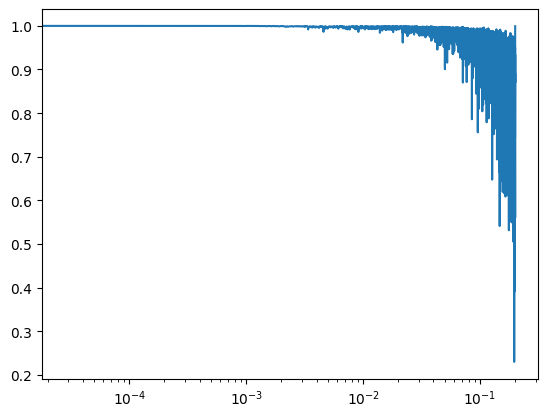

In [17]:
plt.semilogx(ff[0], coh[0])

### Compute Fband Averages

In [18]:
from functions.get_fband_average import __get_fband_average

In [19]:
ff_avg, coh_avg = [], []

for _f, _coh in zip(ff, coh):
    out = __get_fband_average(_f,
                              _coh,
                              faction_of_octave=12,
                              fmin=config['fmin'],
                              fmax=config['fmax'],
                              average='mean',
                              )

    ff_avg.append(out['fcenter'])
    coh_avg.append(out['psd_means'])


### Plotting

In [20]:
def __makeplot_coherence(st_in, ff, coh, ref, twin=None):

    net, sta, loc, cha = ref.split(".")

    st_ref = st_in.select(station=sta, location=loc)
    print(st_ref)
    NN = 2

    font = 12

    if st_ref[0].stats.npts*st_ref[0].stats.delta > 10000:
        time_scaling, time_unit = 1/3600, "hour"
    else:
        time_scaling, time_unit = 1/60, "min"

    fig, ax = plt.subplots(NN, 1, figsize=(15, 8), gridspec_kw={'height_ratios': [1, 3]})

    for tr in st_in:
        ax[0].plot(tr.times()*time_scaling, tr.data, color="grey", alpha=0.5, zorder=1)

    ax[0].plot(st_ref[0].times()*time_scaling, st_ref[0].data, color="k", label=st_ref[0].stats.station+"."+st_ref[0].stats.location, zorder=2)

    for f, c, tr in zip(ff, coh, st_in):
        if tr.stats.station == sta and tr.stats.location == loc:
            ax[1].plot(f, c, color="k", zorder=0, ls="-.", label=tr.stats.station+"."+tr.stats.location)
        else:
            ax[1].plot(f, c, label=tr.stats.station+"."+tr.stats.location, alpha=0.8)

    ax[0].legend(fontsize=font-2)
    ax[1].legend(fontsize=font-2)

    ax[1].set_xscale("log")

    ax[1].set_xlim(config['fmin'], config['fmax'])

    ax[1].grid(ls=":", color="grey", zorder=-1, which="both")

    ax[0].set_title(f"Coherence (f = {config['fmin']*1e3}-{config['fmax']*1e3}mHz | window = {twin}s)",fontsize=font+1, pad=10)
    ax[0].set_ylabel(f"Pressure (Pa)", fontsize=font)
    ax[0].set_xlabel(f"Time ({time_unit}) from {config['tbeg'].date} {str(config['tbeg'].time).split('.')[0]} UTC", fontsize=font)
    ax[1].set_ylabel(f"Coherence", fontsize=font)
    ax[1].set_xlabel(f"Frequency (Hz)", fontsize=font)

    ax[1].set_ylim(0., 1.05)

    plt.show();
    return fig

1 Trace(s) in Stream:
BW.PROMY.03.LDI | 2024-03-23T00:00:00.000000Z - 2024-03-24T23:59:57.500000Z | 0.4 Hz, 69120 samples


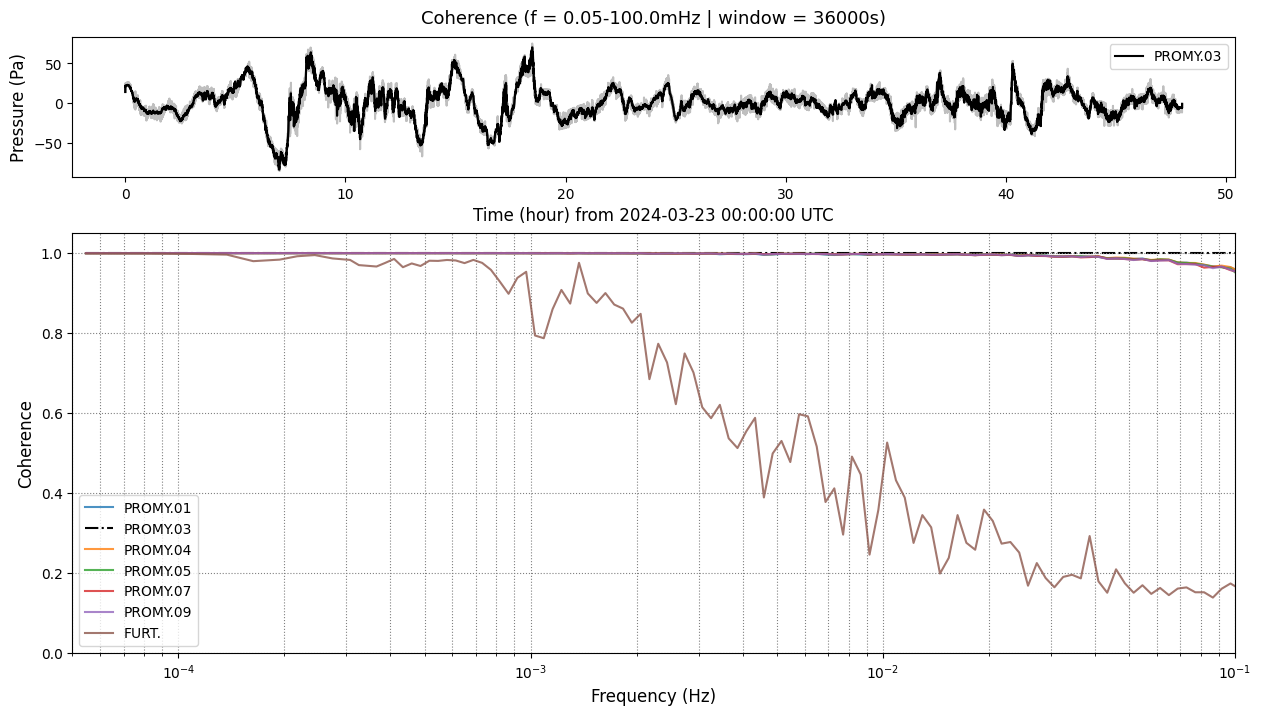

In [21]:
fig = __makeplot_coherence(st, ff_avg, coh_avg, "BW.PROMY.03.LDI", twin=twin)

fig.savefig(config['path_to_figs']+f"BaroArray_Coherence_{config['tbeg'].date}_PS03.png", format="png", dpi=150, bbox_inches='tight')


# fig = __makeplot_coherence(st, ff_avg, coh_avg, "BW.FURT..LAP", twin=twin)

# fig.savefig(config['path_to_figs']+f"BaroArray_Coherence_{config['tbeg'].date}_FURT.png", format="png", dpi=150, bbox_inches='tight')
